In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.optimizers import Nadam, Adam

from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#targetName = "TwoStDayAfterMajRev"
targetName = "TwoStateMajorReversals"

2024-07-30 12:55:13.863169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 12:55:13.863218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 12:55:13.864011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 12:55:13.871033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 12:55:14.855316: W tensorflow/compiler/tf2

In [147]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target=targetName)
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
#targetdf.head()

(2371,)


# LSTM

Note that we do not have any offset data in the current dataset, so we can split cleanly, and won't get future information contaminating our current state.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(stockdf, y_orig, test_size=0.2,shuffle=False)

other_test = otherdf.iloc[-y_test.shape[0]:]

In [149]:
wandb.login(key="d2e07e8a9d7ef675859816d6e8230c50ccd2846d")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [150]:
X_train.shape

(1896, 23)

# Baseline metrics


In [151]:
baseline_model = Sequential([
    #Flatten(),#input_shape=[X_train.shape[0],X_train.shape[1]]),
    Dense(100, activation='sigmoid'),
    Dense(1, activation='sigmoid'),
])

In [152]:
baseline_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
y_base = pd.Categorical(y_train).codes
y_base_test = pd.Categorical(y_test).codes

In [154]:
y_base

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [155]:
baseline_history = baseline_model.fit(X_train, 
                    y_base, 
                    epochs=50, 
                    validation_data=(X_test, y_base_test), 
                    batch_size=32, 
                    verbose=1, 
                    )

Epoch 1/50
60/60 [==============================] - 2s 13ms/step - loss: 0.6148 - accuracy: 0.6904 - val_loss: 0.6797 - val_accuracy: 0.5579
Epoch 2/50
60/60 [==============================] - 1s 12ms/step - loss: 0.5941 - accuracy: 0.6946 - val_loss: 0.6623 - val_accuracy: 0.5579
Epoch 3/50
60/60 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.7046 - val_loss: 0.6790 - val_accuracy: 0.5579
Epoch 4/50
60/60 [==============================] - 0s 8ms/step - loss: 0.5767 - accuracy: 0.7052 - val_loss: 0.6525 - val_accuracy: 0.5537
Epoch 5/50
60/60 [==============================] - 1s 8ms/step - loss: 0.5607 - accuracy: 0.7189 - val_loss: 0.6492 - val_accuracy: 0.5537
Epoch 6/50
60/60 [==============================] - 1s 9ms/step - loss: 0.5518 - accuracy: 0.7189 - val_loss: 0.6291 - val_accuracy: 0.7074
Epoch 7/50
60/60 [==============================] - 1s 9ms/step - loss: 0.5392 - accuracy: 0.7305 - val_loss: 0.6909 - val_accuracy: 0.5579
Epoch 8/50
60/60 [

Silly high accuracy for a simple model


In [156]:
#convert to 1 or 0 around 0.5
bl_preds = np.round(baseline_model.predict(X_test))


15/15 [==============================] - 0s 8ms/step


In [157]:
#Baseline model ROI

import math

bl_actuals = pd.DataFrame(data=bl_preds, columns=["Target"], index=y_test.index.copy())
bl_actuals['close'] = other_test['close']
baseline_ROI = stockutils.calculate_total_gains_bhs(bl_actuals, init_value=1000, init_price=bl_actuals['close'][0])
print("Baseline model ROI:", baseline_ROI)

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all remaining held shares, cash balance: $1375.8400000000001 ***********************
Baseline model ROI: 375.84000000000015


# Buy and hold ROI

In [158]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])
print("Max attainable ROI: ", max_ROI)

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])
bah_ROI

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 174.55, cash balance: $1137.7000000000003
Buying 8 shares for 138.34. Remaining Balance: 30.980000000000246
Selling all shares for 155.74, cash balance: $1276.9000000000003
Buying 9 shares for 134.87. Remaining Balance: 63.07000000000039
Selling all shares for 151.29, cash balance: $1424.6800000000003
Buying 11 shares for 125.02. Remaining Balance: 49.460000000000264
Selling all shares for 155.33, cash balance: $1758.0900000000004
Buying 12 shares for 145.31. Remaining Balance: 14.370000000000346
Selling all shares for 196.45, cash balance: $2371.77
Buying 13 shares for 174.00. Remaining Balance: 109.76999999999998
Selling all shares for 189.70, cash balance: $2575.87
Buying 15 shares for 171.21. Remaining Balance: 7.7199999999998
Selling all shares for 180.71, cash balance: $2718.37
Buying 16 shares for 166.89. Remaining Balance: 48.13000000000011
Selling all shares for 198.11, cash balance: $3217.

62.640000000000015

In [159]:
type(y_train)

pandas.core.series.Series

In [160]:
X_train.shape

(1896, 23)

# Inputs

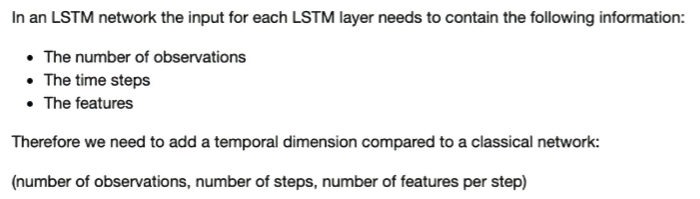

# Configuration

In [161]:
# first, set up our configuration (will be logged)
configs = dict(
    num_classes = 1,
    earlystopping_patience = 15,
    sequence_length = 5,
    epochs = 75,
    optimizer = 'nadam',
    learning_rate = 0.0005,
    targetName = targetName,
    batch_size = 16,
)

## Create Sequences

In [162]:
y_test_orig = y_test.copy()

# Convert y to numbers
y_train= pd.Categorical(y_train).codes
y_test= pd.Categorical(y_test).codes
y_orig= pd.Categorical(y_orig).codes

In [163]:
type(y_train)

numpy.ndarray

In [164]:
# First, we have to convert our dataframes to numpy arrays

X_train = X_train.values
#y_train = y_train.to_numpy() #conversion to categorical (above) does this for us

X_test = X_test.values
#y_test = y_test.to_numpy()

X_orig = stockdf.values
#y_orig = y_orig.to_numpy()

In [165]:
assert(len(X_orig) == len(X_train) + len(X_test))
len(X_orig)

2371

In [166]:
type(X_train)


numpy.ndarray

In [396]:
X_train.shape

(1889, 5, 23)

In [167]:
seq_length = configs['sequence_length']

Xtr = []
ytr = []
Xt = []
yt = []
Xo= []
yo = []
for i in range(seq_length, len(X_train)):
    Xtr.append(X_train[i - seq_length: i, : X_train.shape[1]])
    ytr.append(y_train[i])# starts appending at 0.  Can we use shift() instead? 
# do the same for Xt, yt
for i in range(seq_length, len(X_test)):
    Xt.append(X_test[i -seq_length: i, :X_test.shape[1]])
    yt.append(y_test[i])
for i in range(seq_length, len(X_orig)):
    Xo.append(X_orig[i -seq_length: i, :X_orig.shape[1]])
    yo.append(y_orig[i])

In [168]:
# convert to np arrays again
Xtr = np.array(Xtr)
ytr = np.array(ytr)
Xt = np.array(Xt)
yt = np.array(yt)
Xo = np.array(Xo)
yo = np.array(yo)

In [169]:
Xtr.shape

(1891, 5, 23)

In [372]:
yt.shape

(470,)

# Simple LSTM 

Okay, so now we have the data in the shape we need  (num_observations, seq_length, num_features)

In [171]:


optimizer = Nadam(learning_rate=configs['learning_rate'])

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(Xtr.shape[1], Xtr.shape[2]), name="Where_is_my_mind")) 
#model.add(Dense(16, activation='sigmoid'))
model.add(Dense(configs["num_classes"], activation='sigmoid', name="Im_So_Dense"))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Where_is_my_mind (LSTM)     (None, 50)                14800     
                                                                 
 Im_So_Dense (Dense)         (None, 1)                 51        
                                                                 
Total params: 14851 (58.01 KB)
Trainable params: 14851 (58.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


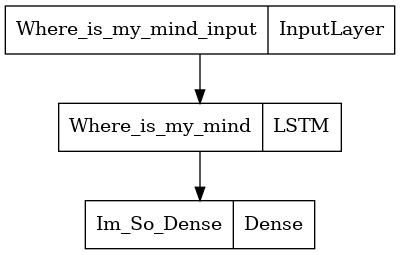

In [172]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="StockLSTM_Model.png")

Set up early stopping so we don't go too long

In [173]:
from keras.callbacks import EarlyStopping
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

es = EarlyStopping(monitor='accuracy', patience=configs['earlystopping_patience'])



In [174]:
#log to weights and biases
run_name = f"LSTMClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=configs)

callbacks = [es, WandbMetricsLogger(), WandbModelCheckpoint("models")]

In [175]:
history = model.fit(Xtr, 
                    ytr, 
                    epochs=configs['epochs'], 
                    validation_data=(Xt, yt), 
                    batch_size=configs['batch_size'], 
                    verbose=1, 
                    callbacks=callbacks,
                    )

run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI



Epoch 1/75
116/119 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.6950INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 33ms/step - loss: 0.6039 - accuracy: 0.6949 - val_loss: 0.6848 - val_accuracy: 0.5532
Epoch 2/75
116/119 [============================>.] - ETA: 0s - loss: 0.5837 - accuracy: 0.6961INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.5843 - accuracy: 0.6954 - val_loss: 0.6738 - val_accuracy: 0.5532
Epoch 3/75
116/119 [============================>.] - ETA: 0s - loss: 0.5647 - accuracy: 0.6999INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.5642 - accuracy: 0.7012 - val_loss: 0.6539 - val_accuracy: 0.5957
Epoch 4/75
116/119 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7177INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.5474 - accuracy: 0.7166 - val_loss: 0.6669 - val_accuracy: 0.5468
Epoch 5/75
118/119 [============================>.] - ETA: 0s - loss: 0.5259 - accuracy: 0.7436INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.5257 - accuracy: 0.7441 - val_loss: 0.7061 - val_accuracy: 0.4851
Epoch 6/75
117/119 [============================>.] - ETA: 0s - loss: 0.5087 - accuracy: 0.7569INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.5089 - accuracy: 0.7573 - val_loss: 0.6740 - val_accuracy: 0.5787
Epoch 7/75
119/119 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.7694INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.5048 - accuracy: 0.7694 - val_loss: 0.6468 - val_accuracy: 0.6426
Epoch 8/75
116/119 [============================>.] - ETA: 0s - loss: 0.4918 - accuracy: 0.7699INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4937 - accuracy: 0.7700 - val_loss: 0.6434 - val_accuracy: 0.6532
Epoch 9/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4862 - accuracy: 0.7750INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4868 - accuracy: 0.7737 - val_loss: 0.6320 - val_accuracy: 0.6660
Epoch 10/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4756 - accuracy: 0.7886INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4750 - accuracy: 0.7879 - val_loss: 0.6566 - val_accuracy: 0.5596
Epoch 11/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4729 - accuracy: 0.7815INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4737 - accuracy: 0.7827 - val_loss: 0.6406 - val_accuracy: 0.5638
Epoch 12/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4654 - accuracy: 0.7859INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4655 - accuracy: 0.7853 - val_loss: 0.6415 - val_accuracy: 0.6255
Epoch 13/75
119/119 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.7879INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 43ms/step - loss: 0.4631 - accuracy: 0.7879 - val_loss: 0.6869 - val_accuracy: 0.5426
Epoch 14/75
118/119 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.7871INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4572 - accuracy: 0.7869 - val_loss: 0.6372 - val_accuracy: 0.6106
Epoch 15/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4474 - accuracy: 0.7978INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.4487 - accuracy: 0.7975 - val_loss: 0.6330 - val_accuracy: 0.6128
Epoch 16/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4550 - accuracy: 0.7940INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.4513 - accuracy: 0.7964 - val_loss: 0.6275 - val_accuracy: 0.6638
Epoch 17/75
116/119 [============================>.] - ETA: 0s - loss: 0.4490 - accuracy: 0.7926INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4467 - accuracy: 0.7943 - val_loss: 0.6392 - val_accuracy: 0.6489
Epoch 18/75
117/119 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.7933INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4424 - accuracy: 0.7916 - val_loss: 0.6274 - val_accuracy: 0.6447
Epoch 19/75
118/119 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8003INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4412 - accuracy: 0.8001 - val_loss: 0.6318 - val_accuracy: 0.5936
Epoch 20/75
117/119 [============================>.] - ETA: 0s - loss: 0.4359 - accuracy: 0.8082INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4371 - accuracy: 0.8070 - val_loss: 0.6309 - val_accuracy: 0.6468
Epoch 21/75
119/119 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8038INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.4354 - accuracy: 0.8038 - val_loss: 0.6266 - val_accuracy: 0.6489
Epoch 22/75
118/119 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8024INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4320 - accuracy: 0.8022 - val_loss: 0.6330 - val_accuracy: 0.6064
Epoch 23/75
117/119 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8002INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 3s 29ms/step - loss: 0.4303 - accuracy: 0.8017 - val_loss: 0.6344 - val_accuracy: 0.6617
Epoch 24/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4246 - accuracy: 0.8022INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4254 - accuracy: 0.8006 - val_loss: 0.6323 - val_accuracy: 0.6596
Epoch 25/75
118/119 [============================>.] - ETA: 0s - loss: 0.4229 - accuracy: 0.8114INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4241 - accuracy: 0.8112 - val_loss: 0.6338 - val_accuracy: 0.6383
Epoch 26/75
119/119 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8033INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4192 - accuracy: 0.8033 - val_loss: 0.6236 - val_accuracy: 0.6511
Epoch 27/75
119/119 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8160INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4155 - accuracy: 0.8160 - val_loss: 0.6193 - val_accuracy: 0.6702
Epoch 28/75
119/119 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8176INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4097 - accuracy: 0.8176 - val_loss: 0.6338 - val_accuracy: 0.6362
Epoch 29/75
117/119 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8146INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.4082 - accuracy: 0.8133 - val_loss: 0.6603 - val_accuracy: 0.6340
Epoch 30/75
117/119 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8152INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.4080 - accuracy: 0.8149 - val_loss: 0.6634 - val_accuracy: 0.6106
Epoch 31/75
117/119 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8114INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4156 - accuracy: 0.8096 - val_loss: 0.6404 - val_accuracy: 0.6426
Epoch 32/75
119/119 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8170INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4037 - accuracy: 0.8170 - val_loss: 0.6200 - val_accuracy: 0.6723
Epoch 33/75
117/119 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8136INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.4002 - accuracy: 0.8133 - val_loss: 0.6167 - val_accuracy: 0.6681
Epoch 34/75
118/119 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8067INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.4024 - accuracy: 0.8059 - val_loss: 0.6370 - val_accuracy: 0.6553
Epoch 35/75
118/119 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8167INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.3920 - accuracy: 0.8170 - val_loss: 0.6203 - val_accuracy: 0.6596
Epoch 36/75
118/119 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8162INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3916 - accuracy: 0.8165 - val_loss: 0.6329 - val_accuracy: 0.6447
Epoch 37/75
119/119 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8176INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3856 - accuracy: 0.8176 - val_loss: 0.6412 - val_accuracy: 0.6362
Epoch 38/75
117/119 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.8301INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3800 - accuracy: 0.8308 - val_loss: 0.6312 - val_accuracy: 0.6638
Epoch 39/75
117/119 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8264INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3837 - accuracy: 0.8271 - val_loss: 0.6364 - val_accuracy: 0.6043
Epoch 40/75
116/119 [============================>.] - ETA: 0s - loss: 0.3792 - accuracy: 0.8287INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3790 - accuracy: 0.8281 - val_loss: 0.6236 - val_accuracy: 0.6574
Epoch 41/75
119/119 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8292INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3745 - accuracy: 0.8292 - val_loss: 0.5977 - val_accuracy: 0.6851
Epoch 42/75
117/119 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8200INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3798 - accuracy: 0.8191 - val_loss: 0.6355 - val_accuracy: 0.6532
Epoch 43/75
118/119 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8257INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.3712 - accuracy: 0.8260 - val_loss: 0.6346 - val_accuracy: 0.6447
Epoch 44/75
117/119 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8296INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3680 - accuracy: 0.8292 - val_loss: 0.6317 - val_accuracy: 0.6638
Epoch 45/75
119/119 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8281INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.3691 - accuracy: 0.8281 - val_loss: 0.6756 - val_accuracy: 0.5894
Epoch 46/75
119/119 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8297INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3680 - accuracy: 0.8297 - val_loss: 0.6121 - val_accuracy: 0.6702
Epoch 47/75
118/119 [============================>.] - ETA: 0s - loss: 0.3597 - accuracy: 0.8347INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.3594 - accuracy: 0.8350 - val_loss: 0.6276 - val_accuracy: 0.6298
Epoch 48/75
117/119 [============================>.] - ETA: 0s - loss: 0.3619 - accuracy: 0.8328INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3611 - accuracy: 0.8334 - val_loss: 0.6401 - val_accuracy: 0.6383
Epoch 49/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3626 - accuracy: 0.8429INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3617 - accuracy: 0.8429 - val_loss: 0.6608 - val_accuracy: 0.6319
Epoch 50/75
119/119 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8371INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 31ms/step - loss: 0.3583 - accuracy: 0.8371 - val_loss: 0.6189 - val_accuracy: 0.6404
Epoch 51/75
118/119 [============================>.] - ETA: 0s - loss: 0.3572 - accuracy: 0.8411INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3570 - accuracy: 0.8414 - val_loss: 0.6126 - val_accuracy: 0.6638
Epoch 52/75
118/119 [============================>.] - ETA: 0s - loss: 0.3530 - accuracy: 0.8358INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3530 - accuracy: 0.8361 - val_loss: 0.6250 - val_accuracy: 0.6596
Epoch 53/75
119/119 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8451INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3449 - accuracy: 0.8451 - val_loss: 0.6226 - val_accuracy: 0.6617
Epoch 54/75
116/119 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8405INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3441 - accuracy: 0.8392 - val_loss: 0.5943 - val_accuracy: 0.6915
Epoch 55/75
119/119 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8477INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.3438 - accuracy: 0.8477 - val_loss: 0.6395 - val_accuracy: 0.6021
Epoch 56/75
117/119 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8381INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3473 - accuracy: 0.8382 - val_loss: 0.6784 - val_accuracy: 0.6128
Epoch 57/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3430 - accuracy: 0.8478INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3410 - accuracy: 0.8493 - val_loss: 0.6077 - val_accuracy: 0.6787
Epoch 58/75
116/119 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8400INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3387 - accuracy: 0.8408 - val_loss: 0.7029 - val_accuracy: 0.5894
Epoch 59/75
119/119 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8525INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3321 - accuracy: 0.8525 - val_loss: 0.6094 - val_accuracy: 0.6638
Epoch 60/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3319 - accuracy: 0.8462INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 44ms/step - loss: 0.3334 - accuracy: 0.8456 - val_loss: 0.7137 - val_accuracy: 0.5702
Epoch 61/75
116/119 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8443INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3369 - accuracy: 0.8440 - val_loss: 0.6431 - val_accuracy: 0.5957
Epoch 62/75
118/119 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8506INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3328 - accuracy: 0.8509 - val_loss: 0.6540 - val_accuracy: 0.5851
Epoch 63/75
116/119 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8438INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3240 - accuracy: 0.8456 - val_loss: 0.6743 - val_accuracy: 0.6191
Epoch 64/75
116/119 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8497INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3295 - accuracy: 0.8498 - val_loss: 0.7336 - val_accuracy: 0.5596
Epoch 65/75
118/119 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.8459INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3282 - accuracy: 0.8461 - val_loss: 0.6408 - val_accuracy: 0.6468
Epoch 66/75
116/119 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.8583INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3189 - accuracy: 0.8562 - val_loss: 0.6761 - val_accuracy: 0.6085
Epoch 67/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3120 - accuracy: 0.8614INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3141 - accuracy: 0.8593 - val_loss: 0.6933 - val_accuracy: 0.5936
Epoch 68/75
117/119 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8595INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.3232 - accuracy: 0.8599 - val_loss: 0.6111 - val_accuracy: 0.6404
Epoch 69/75
118/119 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8485INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3211 - accuracy: 0.8482 - val_loss: 0.6519 - val_accuracy: 0.6106
Epoch 70/75
118/119 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8565INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3166 - accuracy: 0.8556 - val_loss: 0.6599 - val_accuracy: 0.5723
Epoch 71/75
116/119 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8599INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 32ms/step - loss: 0.3247 - accuracy: 0.8609 - val_loss: 0.6341 - val_accuracy: 0.5851
Epoch 72/75
119/119 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8646INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3092 - accuracy: 0.8646 - val_loss: 0.6290 - val_accuracy: 0.6340
Epoch 73/75
118/119 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8596INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.3076 - accuracy: 0.8593 - val_loss: 0.6288 - val_accuracy: 0.6277
Epoch 74/75
119/119 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8646INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3052 - accuracy: 0.8646 - val_loss: 0.6697 - val_accuracy: 0.6170
Epoch 75/75
116/119 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8621INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3066 - accuracy: 0.8625 - val_loss: 0.6599 - val_accuracy: 0.6298


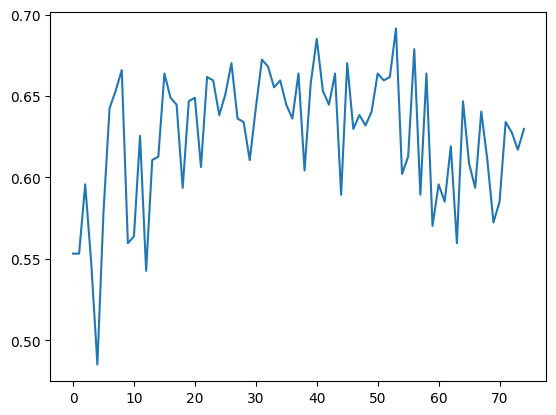

In [176]:
plt.figure()
plt.plot(history.history['val_accuracy'])

In [177]:
Xtp = Xo.copy()

In [178]:
#predictions
testPred = model.predict(Xt)
trainPred = model.predict(Xtr)
fullPred = model.predict(Xo)

#pPred = model.predict(Xtp)

#pPred = np.c_[pPred, np.zeros(pPred.shape)]

74/74 [==============================] - 0s 4ms/step


In [179]:
testPred = np.round(testPred)
trainPred= np.round(trainPred)
fullPred = np.round(fullPred)



In [180]:
y_test_orig = y_test_orig[configs['sequence_length']:]

In [181]:

lstm_preds = pd.DataFrame(data=testPred, columns=["Target"], index=y_test_orig.index.copy())
lstm_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])


Buying 6 shares for 160.01. Remaining Balance: 39.940000000000055
Selling all shares for 167.23, cash balance: $1043.32
Buying 6 shares for 167.53. Remaining Balance: 38.13999999999987
Selling all shares for 161.38, cash balance: $1006.4199999999998
Buying 6 shares for 154.46. Remaining Balance: 79.65999999999985
Selling all shares for 155.31, cash balance: $1011.5199999999999
Buying 6 shares for 152.37. Remaining Balance: 97.29999999999984
Selling all shares for 154.48, cash balance: $1024.1799999999998
Buying 6 shares for 156.90. Remaining Balance: 82.77999999999975
Selling all shares for 153.72, cash balance: $1005.0999999999997
Buying 6 shares for 143.86. Remaining Balance: 141.9399999999996
Selling all shares for 143.39, cash balance: $1002.2799999999995
Buying 6 shares for 149.35. Remaining Balance: 106.17999999999961
Selling all shares for 146.87, cash balance: $987.3999999999996
Buying 6 shares for 149.70. Remaining Balance: 89.1999999999997
Selling all shares for 140.94, cash 

In [182]:
y_test_orig_array = pd.Categorical(y_test_orig).codes
len(y_test_orig_array)

470

In [183]:
run.summary['accuracy'] = accuracy_score(y_test_orig_array, testPred)
wandb.sklearn.plot_confusion_matrix(y_test_orig_array, testPred, ["BUY", "SELL"])



In [184]:
run.finish()

epoch/accuracy,▁▁▂▄▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇█▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
epoch/val_accuracy,▁▁▁▃▆▂▅▄▇▆▃▆▇▅▇▅▆▇▆▅▇▆▆▇▇▅▆▆█▄▇▇▃▅▆▃▄▃▅▅
epoch/val_loss,▇▇▆▇▄▅▄▄▃▃▄▃▄▄▃▆▄▃▃▄▄▃▄▄▂▄▃▃▁▇▂▂▄▇▄█▅▄▃▆
Buy And Hold (Base ROI),62.64
Max ROI,3415.19
ROI,236.76
accuracy,0.62979
epoch/accuracy,0.86251


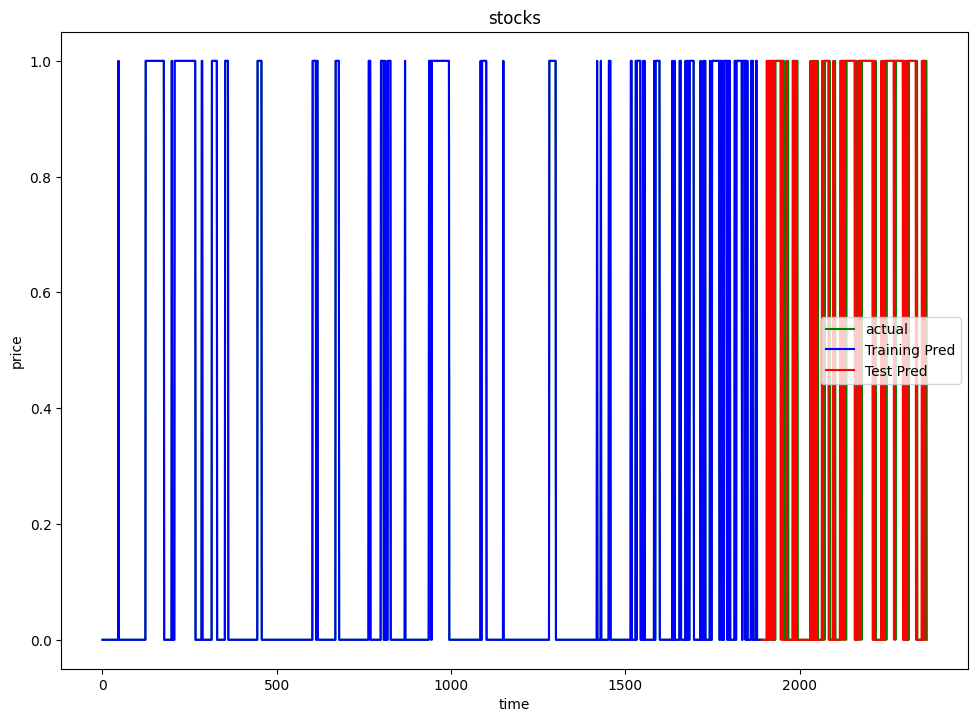

In [185]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

xshift = np.linspace(start=len(trainPred), stop=len(trainPred)+len(testPred),num=len(testPred))

plt.plot(fullPred, 'g', label="actual")
plt.plot(trainPred, "b", label="Training Pred")
plt.plot(xshift, testPred, 'r',label="Test Pred")
#plt.plot(xshift, pPred, 'k',label="REAL Pred")

#plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("stocks")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()

In [186]:
lstm_predictions = targetdf.copy()
lstm_predictions['close'] = otherdf['close']

lstm_predictions = lstm_predictions[configs['sequence_length']:]

In [187]:

lstm_predictions['Target'] = fullPred

lstm_predictions.head()

,Target,close
date,,
1/21/2015,0.0,27.3875
1/22/2015,0.0,28.1000
1/23/2015,0.0,28.2450
1/26/2015,0.0,28.2750
1/27/2015,0.0,27.2850


In [188]:
stockutils.calculate_total_gains_bs(lstm_predictions, init_value=1000, init_price=lstm_predictions['close'][0])

Buying 36 shares for 27.39. Remaining Balance: 14.050000000000068
Selling all shares for 30.81, cash balance: $1123.3000000000002
Buying 35 shares for 31.59. Remaining Balance: 17.562500000000227
Selling all shares for 33.02, cash balance: $1173.1750000000002
Buying 42 shares for 27.59. Remaining Balance: 14.185000000000173
Selling all shares for 30.64, cash balance: $1301.17
Buying 42 shares for 30.50. Remaining Balance: 20.170000000000073
Selling all shares for 28.09, cash balance: $1199.74
Buying 51 shares for 23.43. Remaining Balance: 5.065000000000055
Selling all shares for 25.28, cash balance: $1294.345
Buying 50 shares for 25.57. Remaining Balance: 16.095000000000027
Selling all shares for 26.78, cash balance: $1355.22
Buying 58 shares for 23.13. Remaining Balance: 13.825000000000045
Selling all shares for 24.36, cash balance: $1426.995
Buying 62 shares for 23.01. Remaining Balance: 0.3749999999997726
Selling all shares for 29.56, cash balance: $1833.2499999999998
Buying 68 shar

27573.597500000003

<Axes: xlabel='date', ylabel='close'>

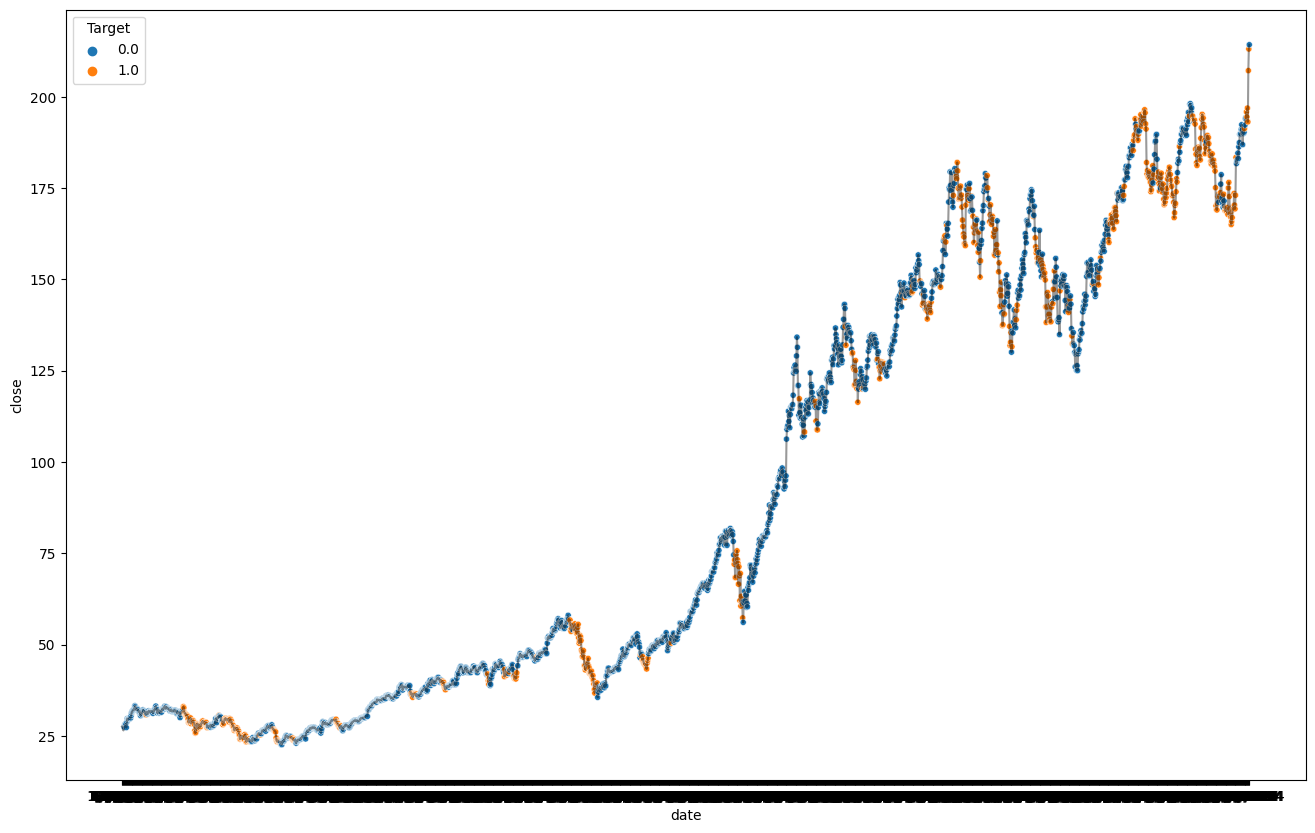

In [189]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=lstm_predictions, x=lstm_predictions.index, y='close', hue='Target',s=20)


If we were predicting price, based on price, we run into a problem where we need to convert our test data to be predictions based on the training data, and compare that to reality.  For Buy/Sell signals, there is no dependency on previous buy/sell signals (there still is price, but test dat is real data with no dependency on buy/sell signals)

# LSTM Stacked Model - more than one layer of LSTM

I will also make this one predict into the future...

In [444]:
# first, set up our configuration (will be logged)
configs = dict(
    num_classes = 2,
    earlystopping_patience = 10,
    sequence_length = 5,
    epochs = 20,
    optimizer = 'nadam',
    learning_rate = 0.001,
    targetName = targetName,
    batch_size = 16,
)

In [445]:
# lets start over with the data
import stockutils

stockdf, targetdf, otherdf = stockutils.import_stock_csv(filename="AAPL_Advanced.csv", target=targetName)#, debug_counter=True)
y_orig = targetdf["Target"]
print(y_orig.shape)

(2371,)


A way to create sequences of a given sequence length and prediction horizion

Note that we are doing it before the split, in order to capture data that crosses the boundary between train and test

Our data loses seq_len + pred_horizon samples from the end
y_data loses seq_len samples from the beginning.
X_data 

In [446]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

sequence_length = configs['sequence_length'] # Length of input sequences
prediction_horizon = configs['sequence_length']#configs['sequence_length']  # Predict 5 days ahead

#NOTE I cannot get this to work unless the sequence length == prediction_horizon

# def create_sequences(X_data, y_data, seq_length, pred_horizon):
#     xs, ys = [], []
#     # we will chop off seq_length + pred_horizon samples from the end of our  data len(xdata)=2371, so 2361 total
#     for i in range(len(X_data) - seq_length - pred_horizon):  # from 0 to the chop point
#         #This slice represents one input sequence for the LSTM model. copying seq_length future steps to each x, (so we get a list at each x index)
#         x = X_data[i:(i + seq_length)]  # first value is X_data[0:5]
#         # for y, we copy the  'pred_horizon' targets to each y, offset from x by seq_length (these are the actual BUY or SELL signals), and extends to the prediction horizon
#         y = y_data[(i + seq_length):(i + seq_length + pred_horizon)] # first value is y_data[5:10], last is y_data[2365:2370]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)


# # Create sequences and labels
# #### X, y = create_sequences(stockdf.values, y_cat, sequence_length, prediction_horizon)
# X, y = create_sequences(stockdf.values, targetdf.values, sequence_length, prediction_horizon)

In [447]:
targetdf.values[0][0]

'SELL'

In [448]:
def create_sequences(X_data, y_data, seq_length, pred_horizon):
    xs, ys = [], []
    # we will chop off seq_length + pred_horizon samples from the end of our  data len(xdata)=2371, so 2361 total
    for i in range(seq_length, 1+len(X_data) - pred_horizon):  # i is from 4 to 38=(42-4)
        #This slice represents one input sequence for the LSTM model. copying seq_length future steps to each x, (so we get a list at each x index)
        x = X_data[i-seq_length : i]  # first value is X_data[0:5]
        # for y, we copy the  'pred_horizon' targets to each y, offset from x by seq_length (these are the actual BUY or SELL signals), and extends to the prediction horizon
        #if pred_horizon == 1:
        #    y= y_data[i][0]
        #else:
        y = y_data[(i):(i + pred_horizon)] # first value is y_data[5:10], last is y_data[2365:2370]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [449]:
X, y = create_sequences(stockdf.values, targetdf.values, sequence_length, prediction_horizon)

In [450]:
X.shape, y.shape

((2362, 5, 23), (2362, 5, 1))

So we lost sequence_length off the front of y, and prediction_horizion off the back end, (could not fill in due to lack of data beyond 2365)
Need to shift our dates for correlating date with predictions

In [451]:
y_plot_df = targetdf[sequence_length:-prediction_horizon]
price_df = otherdf[sequence_length:-prediction_horizon]

#y_plot_df

#### Calculate buy and hold ROI - Put somewhere else

In [452]:
# import math

# other_test = otherdf.iloc[-y_data.shape[0]:]

# bah_actuals = pd.DataFrame(data=y_data, columns=["Target"], index=y_data.index.copy())
# bah_actuals['close'] = other_test['close']
# max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])
# print("Max attainable ROI: ", max_ROI)

# num_bought = math.floor(1000/ bah_actuals['close'][0])
# bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])
# bah_ROI

Our X data is in the correct shape that we need, but if not
Reshape X to fit LSTM input shape [samples, time steps, features]  

> X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

Y data, however needs to be converted to categoricals one-hot encoding.  This works generally, even though we could technically do a single output... 

In [453]:
# Reshape y to match the expected output shape [samples, time steps, classes]
y_flat = y.flatten()
label_encoder = LabelEncoder()  # we will use this later to reverse 
y_encoded = label_encoder.fit_transform(y_flat)


In [454]:
y.ndim

3

In [455]:
y_cat = to_categorical(y_encoded)
y_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [456]:
y_cat = to_categorical(y_encoded)

#if y.ndim > 1:
# Reshape y back to match the model output shape
y_cat = y_cat.reshape(y.shape[0], y.shape[1], -1)

## Create the model

In [457]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
import stockutils

num_features = 23  # X.shape[2]
num_classes = 2  # Binary classification: BUY or SELL  y_cat.shape[2]

optimizer = Adam(learning_rate=configs['learning_rate'])

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(50, activation='tanh', return_sequences=True, dropout=0.2))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 5, 50)             14800     
                                                                 
 lstm_47 (LSTM)              (None, 5, 50)             20200     
                                                                 
 lstm_48 (LSTM)              (None, 5, 50)             20200     
                                                                 
 lstm_49 (LSTM)              (None, 5, 50)             20200     
                                                                 
 time_distributed_16 (TimeD  (None, 5, 2)              102       
 istributed)                                                     
                                                                 
Total params: 75502 (294.93 KB)
Trainable params: 75502 (294.93 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

### Log in to Weights and biases for tracking

In [458]:
run_name = f"StackedLSTMClassifier_2_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=configs)

### Train Test Split

In [459]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42, shuffle=False)

test_price_df = price_df[-len(y_test):]
train_price_df = price_df[:len(y_train)]



In [460]:
y_test.shape

(473, 5, 2)

# Fit

In [461]:
from sklearn.model_selection import train_test_split

es = EarlyStopping(monitor='accuracy', patience=configs['earlystopping_patience'])

callbacks = [es, WandbMetricsLogger(), WandbModelCheckpoint("models")]
#callbacks = [es]

# Train the model
model2_history = model.fit(X_train, y_train, epochs=configs['epochs'], batch_size=configs['batch_size'], validation_data=(X_test, y_test), callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/20
117/119 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.6968INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 23s 125ms/step - loss: 0.6305 - accuracy: 0.6949 - val_loss: 0.6895 - val_accuracy: 0.5560
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.6936INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 106ms/step - loss: 0.6163 - accuracy: 0.6936 - val_loss: 0.6875 - val_accuracy: 0.5560
Epoch 3/20
117/119 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.6948INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 108ms/step - loss: 0.6032 - accuracy: 0.6957 - val_loss: 0.6913 - val_accuracy: 0.5332
Epoch 4/20
119/119 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.6881INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 14s 115ms/step - loss: 0.5961 - accuracy: 0.6881 - val_loss: 0.6880 - val_accuracy: 0.5488
Epoch 5/20
119/119 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.6999INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 15s 129ms/step - loss: 0.5737 - accuracy: 0.6999 - val_loss: 0.6644 - val_accuracy: 0.5852
Epoch 6/20
117/119 [============================>.] - ETA: 0s - loss: 0.5665 - accuracy: 0.7009INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 109ms/step - loss: 0.5666 - accuracy: 0.7012 - val_loss: 0.6876 - val_accuracy: 0.5391
Epoch 7/20
119/119 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7120INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 106ms/step - loss: 0.5565 - accuracy: 0.7120 - val_loss: 0.6704 - val_accuracy: 0.5467
Epoch 8/20
119/119 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7212INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 110ms/step - loss: 0.5514 - accuracy: 0.7212 - val_loss: 0.6592 - val_accuracy: 0.6161
Epoch 9/20
118/119 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7285INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 15s 130ms/step - loss: 0.5430 - accuracy: 0.7286 - val_loss: 0.6740 - val_accuracy: 0.5679
Epoch 10/20
119/119 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7256INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 109ms/step - loss: 0.5400 - accuracy: 0.7256 - val_loss: 0.6762 - val_accuracy: 0.5818
Epoch 11/20
117/119 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.7369INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 110ms/step - loss: 0.5337 - accuracy: 0.7361 - val_loss: 0.6617 - val_accuracy: 0.5488
Epoch 12/20
119/119 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7220INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 112ms/step - loss: 0.5435 - accuracy: 0.7220 - val_loss: 0.6732 - val_accuracy: 0.5493
Epoch 13/20
118/119 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.7351INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 17s 141ms/step - loss: 0.5278 - accuracy: 0.7352 - val_loss: 0.6746 - val_accuracy: 0.5725
Epoch 14/20
117/119 [============================>.] - ETA: 0s - loss: 0.5282 - accuracy: 0.7287INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 16s 135ms/step - loss: 0.5289 - accuracy: 0.7279 - val_loss: 0.6795 - val_accuracy: 0.5721
Epoch 15/20
119/119 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.7376INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 106ms/step - loss: 0.5216 - accuracy: 0.7376 - val_loss: 0.6798 - val_accuracy: 0.5751
Epoch 16/20
119/119 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.7433INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 110ms/step - loss: 0.5173 - accuracy: 0.7433 - val_loss: 0.6839 - val_accuracy: 0.5514
Epoch 17/20
118/119 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.7376INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 110ms/step - loss: 0.5198 - accuracy: 0.7377 - val_loss: 0.6663 - val_accuracy: 0.5493
Epoch 18/20
118/119 [============================>.] - ETA: 0s - loss: 0.5094 - accuracy: 0.7456INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 16s 132ms/step - loss: 0.5092 - accuracy: 0.7457 - val_loss: 0.6703 - val_accuracy: 0.5539
Epoch 19/20
118/119 [============================>.] - ETA: 0s - loss: 0.5039 - accuracy: 0.7446INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 13s 108ms/step - loss: 0.5037 - accuracy: 0.7447 - val_loss: 0.6802 - val_accuracy: 0.5548
Epoch 20/20
117/119 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7499INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


15/15 [==============================] - 0s 21ms/step - loss: 0.6774 - accuracy: 0.5518
Test Loss: 0.6774401068687439, Test Accuracy: 0.5517970323562622


# Predict

In [462]:
testPred = model.predict(X_test)
testPred_labels = np.argmax(testPred, axis=-1)

testPred_labels

15/15 [==============================] - 2s 12ms/step


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [463]:
# Decode predictions back to original labels
decoded_preds = label_encoder.inverse_transform(testPred_labels.flatten())
decoded_preds

array(['BUY', 'BUY', 'BUY', ..., 'BUY', 'BUY', 'BUY'], dtype=object)

In [464]:


# Reshape to match the original shape of the test labels
decoded_preds = decoded_preds.reshape(testPred_labels.shape)

decoded_preds.shape

(473, 5)

In [465]:
decoded_ytest  =  y_test[:,:,1].astype(int)
#decoded_ytest #

In [466]:
#Also to the y_test
# Decode predictions back to original labels
y_test_decoded = label_encoder.inverse_transform(decoded_ytest.flatten())


In [467]:
# Reshape to match the original shape of the test labels
y_test_decoded = y_test_decoded.reshape(decoded_ytest.shape)
#y_test_decoded

In [468]:
dates = test_price_df.index
#dates

In [469]:
#days_in_advance = 0
lstm_preds = pd.DataFrame(data=decoded_preds[:,0], columns=["Target"], index=test_price_df.index)


In [470]:

lstm_preds['close'] = test_price_df['close']

run.summary["ROI"] = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])

#lstm_preds

Buying 6 shares for 155.35. Remaining Balance: 67.90000000000009
Selling all remaining held shares, cash balance: $1234.78 ***********************


In [471]:

stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])

Buying 6 shares for 155.35. Remaining Balance: 67.90000000000009
Selling all remaining held shares, cash balance: $1234.78 ***********************


234.77999999999997

: 

In [383]:
#flatten the sequences to get accuracy
accuracy = accuracy_score(y_test_decoded.flatten(), decoded_preds.flatten())
accuracy


0.5801268498942918

In [384]:
run.summary['accuracy'] = accuracy_score(y_test_decoded.flatten(), decoded_preds.flatten())
#wandb.sklearn.plot_confusion_matrix(y_test_orig_array, testPred, ["BUY", "SELL"])

In [385]:
run.finish()

epoch/accuracy,▁▁▁▁▂▃▃▄▄▄▅▅▆▆▆▇██▇█
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▄▃▄▃▃▃▂▂▂▁▁▁▁▁
epoch/val_accuracy,▄▄▅▄▆▇▄▄█▄█▂▁▃▂▂▇▅▃▆
epoch/val_loss,▃█▃▃▁▁▃▂▂▃▂▂▃▁▂▂▂▂▂▂
ROI,447.23
accuracy,0.58013
epoch/accuracy,0.7478
epoch/epoch,19
epoch/learning_rate,0.001


<Axes: xlabel='date', ylabel='close'>

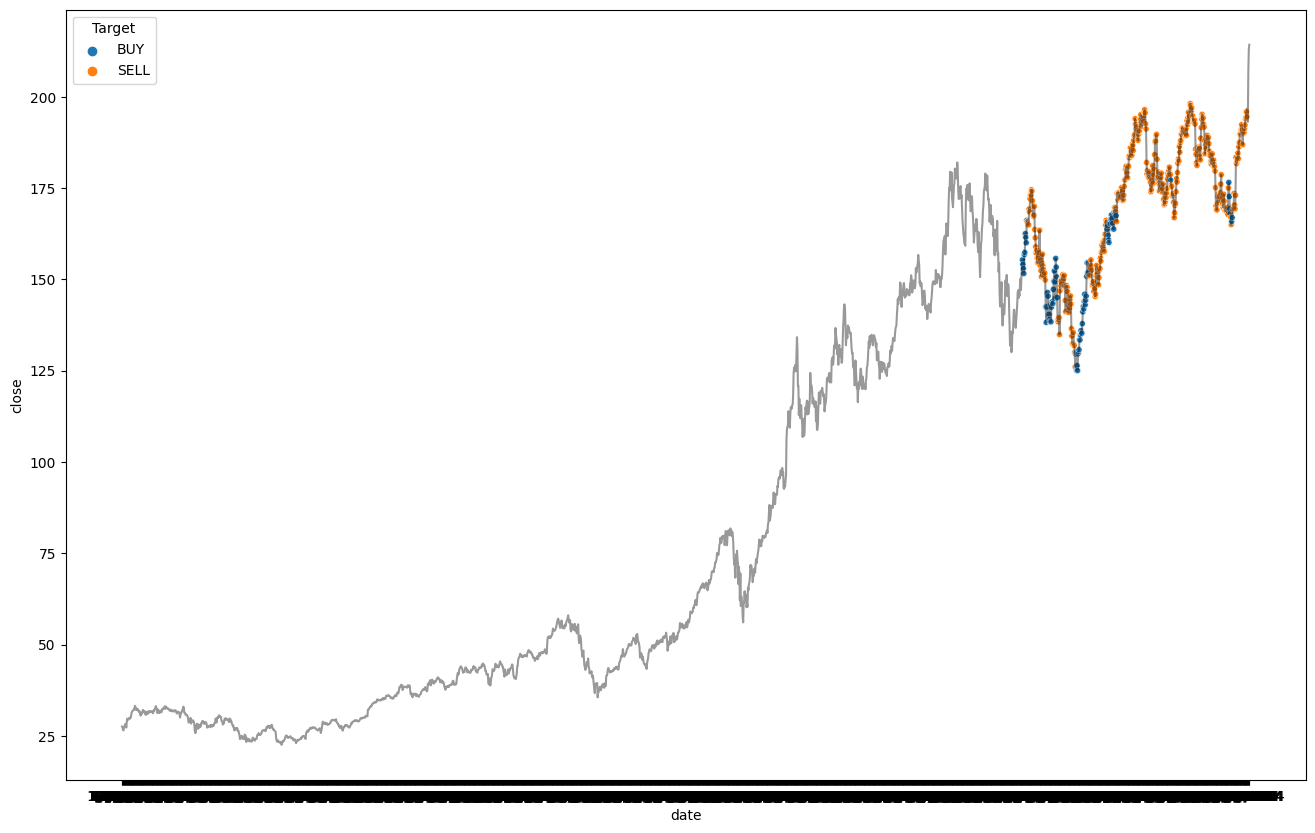

In [330]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=lstm_preds, x=lstm_preds.index, y='close', hue='Target',s=20)